## 🧭 **Notebook 1 — Exploring Demand Recovery in Europe After COVID-19**

## Part I. Data Preparation and Cleaning

### 🟩 1. Setup and Imports

In [1]:
# --- Basic setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Plot style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# Data path
DATA_PATH = Path("../data/processed/hotel_panel.csv")

### 🟩 2. Load dataset

In [2]:
df = pd.read_csv(DATA_PATH, parse_dates=["month"])
df["year"] = df["month"].dt.year

print("✅ Dataset loaded:", df.shape)
df.head()

✅ Dataset loaded: (3328, 14)


,region,time_x,nights_spent,gdp,unemployment_rate,turnover_index,hicp_index,month,covid_cases,eurgbp,eurusd,time_y,policy_stringency,year
0,AT,2015-01-31,1833949.0,61688.9,5.5,NaN,98.48,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
1,BE,2015-01-31,388967.0,76937.9,8.4,NaN,97.20,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
2,BG,2015-01-31,337119.0,5283.4,10.7,55.8,99.80,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
3,CY,2015-01-31,37399.0,3211.6,17.3,52.7,98.31,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
4,CZ,2015-01-31,798556.0,28837.2,6.7,79.7,99.50,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015


### 🟩 3. Key integrity check block

In [3]:
# --- Integrity checks: keys and timestamps ---
print("🔍 Checking time and region consistency...")

# 1️⃣ Check that all time columns match (time_x, time_y, month)
time_cols = ["time_x", "time_y", "month"]
existing_time_cols = [c for c in time_cols if c in df.columns]

if len(existing_time_cols) >= 2:
    ref = df[existing_time_cols[0]].astype(str)
    identical = True
    for col in existing_time_cols[1:]:
        if not (df[col].astype(str) == ref).all():
            identical = False
            mismatches = df.loc[df[col].astype(str) != ref, ["region"] + existing_time_cols]
            print(f"❌ {col} differs from {existing_time_cols[0]} in {len(mismatches)} rows")
    if identical:
        print(f"✅ All time columns {existing_time_cols} are identical.")
        # Keep a single canonical 'month' column
        df["month"] = pd.to_datetime(df["month"])
        df = df.drop(columns=[c for c in existing_time_cols if c != "month"], errors="ignore")
else:
    print("⚠️ Not all time columns found — skipping time check.")

# 🔒 Duplicate key guard — add here (after month is canonical)
dupes = df.duplicated(subset=["region", "month"]).sum()
assert dupes == 0, f"Found {dupes} duplicate region-month rows"

# (Optional) ensure chronological order within region
df = df.sort_values(["region", "month"]).reset_index(drop=True)

# 2️⃣ Validate EU region codes
EU = [
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","GR","HR","HU",
    "IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
]
invalid = df.loc[~df["region"].isin(EU), "region"].unique()
if len(invalid) == 0:
    print(f"✅ All region codes valid ({len(EU)} EU countries).")
else:
    print(f"❌ Invalid region codes detected: {invalid}")

# 3️⃣ Confirm each region has full monthly coverage
coverage = df.groupby("region")["month"].nunique()
if coverage.nunique() == 1:
    print(f"✅ Each country has {coverage.iloc[0]} monthly records.")
else:
    print("⚠️ Uneven month coverage:", coverage.describe())

🔍 Checking time and region consistency...
✅ All time columns ['time_x', 'time_y', 'month'] are identical.
✅ All region codes valid (27 EU countries).
✅ Each country has 128 monthly records.


In [4]:
dupes = df.duplicated(subset=["region","month"]).sum()
assert dupes == 0, f"Found {dupes} duplicate region-month rows"

In [5]:
# --- Reorder columns logically ---
desired_order = [
    "region", "month", "year",
    "nights_spent",
    "gdp", "unemployment_rate", "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]

# Include any other remaining columns at the end
remaining = [c for c in df.columns if c not in desired_order]
df = df[desired_order + remaining]

print("✅ Columns reordered logically:")
print(df.columns.tolist())
df.head()

✅ Columns reordered logically:
['region', 'month', 'year', 'nights_spent', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp']


,region,month,year,nights_spent,gdp,unemployment_rate,turnover_index,hicp_index,covid_cases,policy_stringency,eurusd,eurgbp
0,AT,2015-01-31,2015,1833949.0,61688.9,5.5,NaN,98.48,NaN,NaN,1.128796,0.748800
1,AT,2015-02-28,2015,2145686.0,NaN,5.9,NaN,98.75,NaN,NaN,1.119796,0.726058
2,AT,2015-03-31,2015,1934635.0,NaN,5.4,NaN,100.15,NaN,NaN,1.083025,0.731200
3,AT,2015-04-30,2015,1468507.0,62955.6,5.6,NaN,100.28,NaN,NaN,1.111432,0.720400
4,AT,2015-05-31,2015,1792973.0,NaN,5.8,NaN,100.45,NaN,NaN,1.096035,0.715400


### 🟩 4. Quick overview

In [6]:
df.info()
display(df.describe().T.round(2))

# Missingness overview
(df.isna().mean() * 100).round(1).sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   region             3328 non-null   object        
 1   month              3328 non-null   datetime64[ns]
 2   year               3328 non-null   int32         
 3   nights_spent       3292 non-null   float64       
 4   gdp                1084 non-null   float64       
 5   unemployment_rate  3328 non-null   float64       
 6   turnover_index     2631 non-null   float64       
 7   hicp_index         3328 non-null   float64       
 8   covid_cases        1456 non-null   float64       
 9   policy_stringency  936 non-null    float64       
 10  eurusd             3328 non-null   float64       
 11  eurgbp             3328 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(1), object(1)
memory usage: 299.1+ KB


,count,mean,min,25%,50%,75%,max,std
month,3328,2020-05-15 15:22:30,2015-01-31 00:00:00,2017-09-22 12:00:00,2020-05-15 12:00:00,2023-01-07 18:00:00,2025-08-31 00:00:00,NaN
year,3328.0,2019.84375,2015.0,2017.0,2020.0,2022.25,2025.0,3.083779
nights_spent,3292.0,2645412.065006,0.0,175969.5,840674.0,2193637.0,30196895.0,4765346.995994
gdp,1084.0,97493.757565,1681.0,8305.525,35910.0,90441.5,669989.9,154906.48569
unemployment_rate,3328.0,6.672356,2.0,4.6,6.0,7.7,25.1,3.238143
turnover_index,2631.0,132.025162,6.3,95.35,126.1,165.55,419.6,53.23439
hicp_index,3328.0,112.963167,96.29,101.6075,106.565,120.45,174.87,15.227927
covid_cases,1456.0,756.280179,0.0,20.557506,151.123928,743.462982,17927.075295,1698.575083
policy_stringency,936.0,40.057056,0.0,15.15125,42.049032,57.554919,95.434667,23.431209
eurusd,3328.0,1.118962,0.982956,1.084225,1.115387,1.157142,1.240957,0.051836


policy_stringency    71.9
gdp                  67.4
covid_cases          56.2
turnover_index       20.9
nights_spent          1.1
region                0.0
month                 0.0
year                  0.0
unemployment_rate     0.0
hicp_index            0.0
eurusd                0.0
eurgbp                0.0
dtype: float64

### 🟩 5. Completeness by year

In [7]:
coverage = (
    df.groupby("year")[['region', 'month', 'nights_spent', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp']]
    .apply(lambda x: x.notna().mean().round(2))
)
coverage.tail(15)

,region,month,nights_spent,gdp,unemployment_rate,turnover_index,hicp_index,covid_cases,policy_stringency,eurusd,eurgbp
year,,,,,,,,,,,
2015,1.0,1.0,0.96,0.33,1.0,0.69,1.0,0.00,0.0,1.0,1.0
2016,1.0,1.0,0.96,0.33,1.0,0.69,1.0,0.00,0.0,1.0,1.0
2017,1.0,1.0,1.00,0.33,1.0,0.69,1.0,0.00,0.0,1.0,1.0
2018,1.0,1.0,1.00,0.33,1.0,0.69,1.0,0.00,0.0,1.0,1.0
2019,1.0,1.0,0.96,0.33,1.0,0.69,1.0,0.00,0.0,1.0,1.0
2020,1.0,1.0,1.00,0.33,1.0,0.73,1.0,1.00,1.0,1.0,1.0
2021,1.0,1.0,1.00,0.33,1.0,0.92,1.0,1.00,1.0,1.0,1.0
2022,1.0,1.0,1.00,0.33,1.0,0.92,1.0,1.00,1.0,1.0,1.0
2023,1.0,1.0,1.00,0.33,1.0,0.92,1.0,1.00,0.0,1.0,1.0


### 🟩 6. Imputation

🧮 **Recommended Imputation Strategy** (Variable by Variable)

| Variable              | Typical missingness       | Recommended method                                                                              | Rationale                                                                                                  |
| --------------------- | ------------------------- | ----------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **GDP**               | 67% (quarterly → monthly) | **Linear interpolation by region**                                                              | GDP is smooth and low-frequency; linear interpolation preserves macro trend continuity.                    |
| **Turnover index**    | ~21%                      | **Group-wise linear interpolation**, optionally with *rolling median* smoothing                 | Seasonal but continuous; interpolation restores monthly continuity.                                        |
| **COVID cases**       | 56%                       | **Fill NA=0 before 2020**, **linear interpolation (2020–2024)**, then 0 again if missing after  | COVID started only in 2020; missing pre-COVID = real zeros. Some gaps in 2024–2025 can be filled smoothly. |
| **Policy stringency** | 72%                       | **Fill NA=0 before 2020**, **group-wise linear interpolation**, optional *3-month rolling mean* | Index disappeared after restrictions eased — missing = 0 (no measures).                                    |
| **Nights spent**      | ~1%                       | **Interpolate within region**, optionally *rolling mean smoothing*                              | Very few gaps; maintain natural seasonality without bias.                                                  |


In [8]:
df_clean = df.copy()
df_clean = df_clean.sort_values(["region", "month"])

# GDP and turnover: smooth economic indicators
for col in ["gdp", "turnover_index"]:
    if col in df_clean.columns:
        df_clean[col] = (
            df_clean.groupby("region")[col]
            .apply(lambda s: s.interpolate(limit_direction="both"))
            .reset_index(level=0, drop=True)
        )

# COVID and policy stringency: zeros before 2020, interpolate after
for col in ["covid_cases", "policy_stringency"]:
    if col in df_clean.columns:
        df_clean.loc[df_clean["year"] < 2020, col] = 0
        df_clean[col] = (
            df_clean.groupby("region")[col]
            .apply(lambda s: s.interpolate(limit_direction="both"))
            .reset_index(level=0, drop=True)
        )
        df_clean[col] = df_clean[col].fillna(0)

# Nights spent: minor interpolation
df_clean["nights_spent"] = (
    df_clean.groupby("region")["nights_spent"]
    .apply(lambda s: s.interpolate(limit_direction="both"))
    .reset_index(level=0, drop=True)
)

print("✅ Imputation complete.")
print(df_clean.isna().mean().sort_values(ascending=False))

✅ Imputation complete.
turnover_index       0.038462
region               0.000000
month                0.000000
year                 0.000000
nights_spent         0.000000
gdp                  0.000000
unemployment_rate    0.000000
hicp_index           0.000000
covid_cases          0.000000
policy_stringency    0.000000
eurusd               0.000000
eurgbp               0.000000
dtype: float64


In [9]:
# --- Final pass for turnover_index ---
def fill_turnover(s):
    # Interpolate normally
    s = s.interpolate(limit_direction="both")
    # If entire segment is NaN (no data at all), fill with group median
    if s.isna().all():
        s[:] = np.nan
    # Fill any remaining edge NAs using forward/backward fill
    s = s.ffill().bfill()
    # If still NA (rare), fill with overall median
    s = s.fillna(df_clean["turnover_index"].median())
    return s

df_clean["turnover_index"] = (
    df_clean.groupby("region")["turnover_index"]
    .apply(fill_turnover)
    .reset_index(level=0, drop=True)
)

print("✅ turnover_index final missing share:",
      df_clean["turnover_index"].isna().mean().round(4))

✅ turnover_index final missing share: 0.0


In [10]:
# --- Save clean dataset ---
CLEAN_PATH = Path("../data/processed/hotel_panel_clean.csv")
df_clean.to_csv(CLEAN_PATH, index=False)
print(f"💾 Clean dataset saved → {CLEAN_PATH.resolve()}")

💾 Clean dataset saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_panel_clean.csv


## Part II. Exploratory Data Analysis and Data Refinement

### 🟩 7. Reload clean dataset

In [11]:
# --- Load clean dataset for EDA ---

EDA_PATH = Path("../data/processed/hotel_panel_clean.csv")
eda = pd.read_csv(EDA_PATH, parse_dates=["month"])
print("✅ Clean dataset loaded for EDA:", eda.shape)

✅ Clean dataset loaded for EDA: (3328, 12)


### 🟩 8. Define pandemic phases

In [12]:
def classify_period(year):
    if year < 2020:
        return "Pre-COVID"
    elif 2020 <= year <= 2022:
        return "COVID"
    else:
        return "Post-COVID"

eda["period"] = eda["year"].apply(classify_period)
eda["period"].value_counts()

period
Pre-COVID     1560
COVID          936
Post-COVID     832
Name: count, dtype: int64

### 🟩 9. EU-level trends (hotel nights vs. COVID)

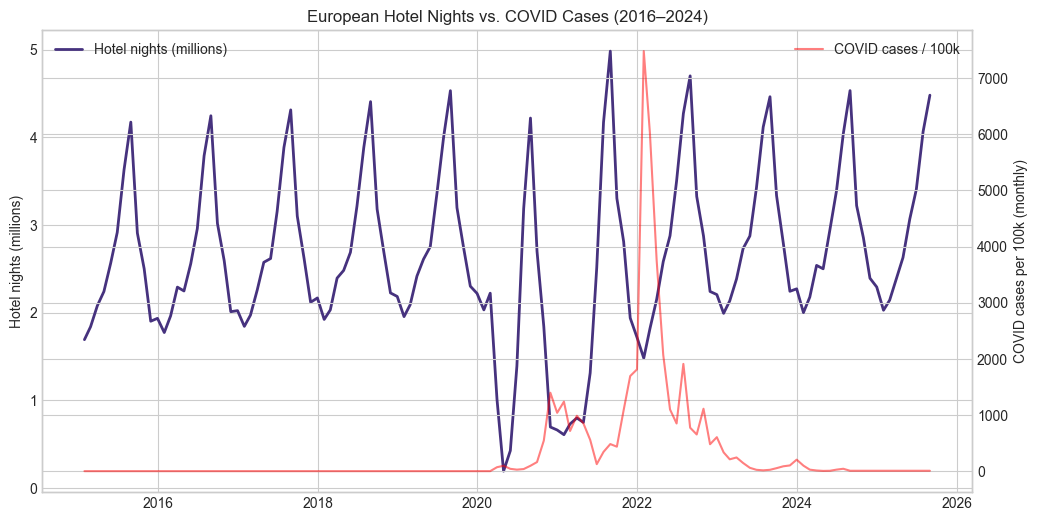

In [13]:
agg = (
    eda.groupby("month")[["nights_spent", "gdp", "unemployment_rate", "covid_cases"]]
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(agg["month"], agg["nights_spent"]/1e6, label="Hotel nights (millions)", linewidth=2)
ax1.set_ylabel("Hotel nights (millions)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(agg["month"], agg["covid_cases"], color="red", alpha=0.5, label="COVID cases / 100k")
ax2.set_ylabel("COVID cases per 100k (monthly)")
ax2.legend(loc="upper right")

plt.title("European Hotel Nights vs. COVID Cases (2016–2024)")
plt.show()

### 🟩 10. Country-level recovery heatmaps

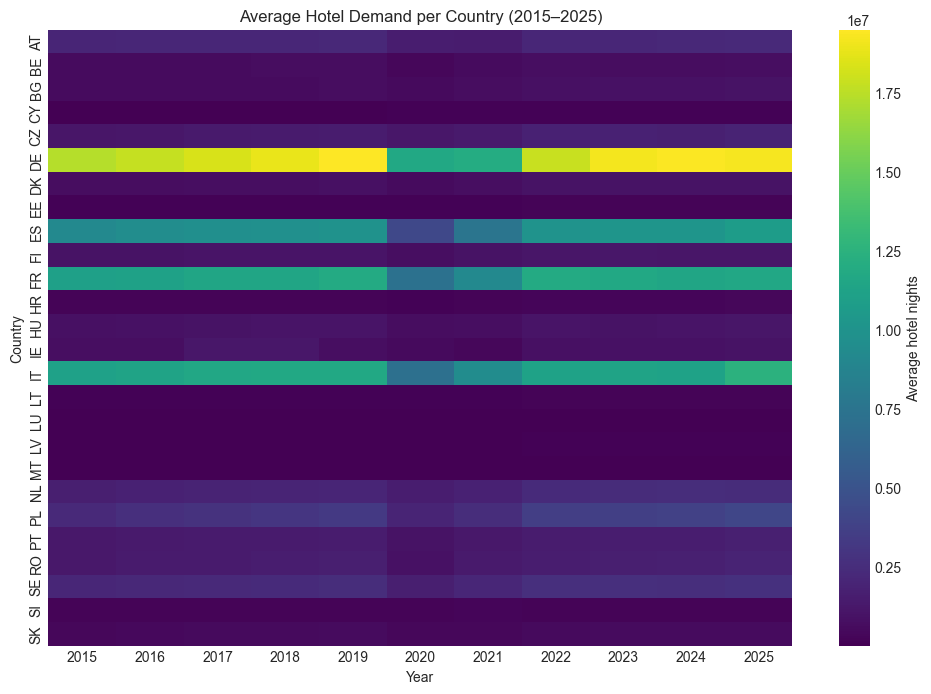

In [14]:
pivot = eda.pivot_table(
    index="region", columns="year", values="nights_spent", aggfunc="mean"
)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Average hotel nights'})
plt.title("Average Hotel Demand per Country (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.show()

### 🟩 11. Indicator distributions (GDP, unemployment, turnover, etc.)

[INFO] Plotting distributions for 9 numeric indicators.


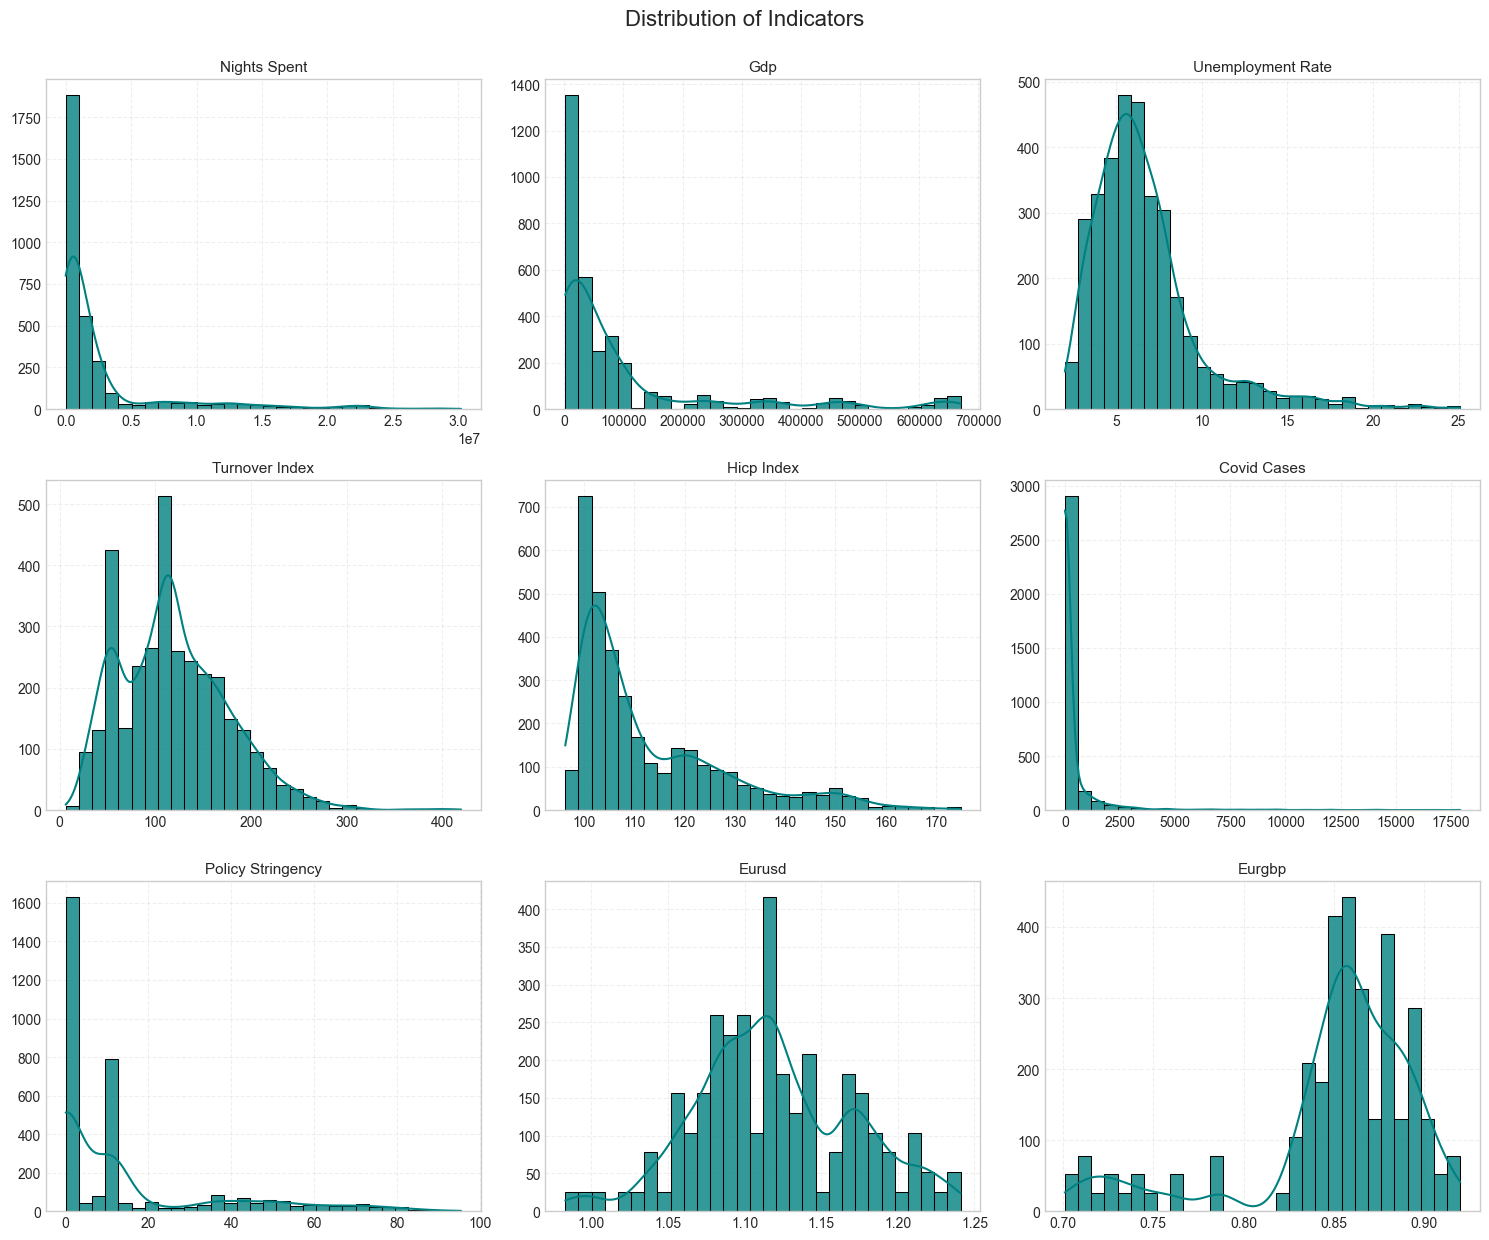

In [15]:
# === Distribution of Indicators ===

# --- Define numeric columns of interest ---
numeric_cols_all = [
    "nights_spent", "gdp", "unemployment_rate",
    "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]

# --- Filter to columns present and valid ---
numeric_cols_all = [c for c in numeric_cols_all if c in eda.columns and eda[c].nunique() > 3]
print(f"[INFO] Plotting distributions for {len(numeric_cols_all)} numeric indicators.")

# --- Grid layout (3x3 since we have 9 plots) ---
n_cols = 3
n_rows = math.ceil(len(numeric_cols_all) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# --- Plot histograms ---
for i, col in enumerate(numeric_cols_all, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        eda[col].dropna(),
        kde=True,
        bins=30,
        color="teal",
        alpha=0.8,
    )
    plt.title(col.replace("_", " ").title(), fontsize=11)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.suptitle("Distribution of Indicators", fontsize=16, y=1.03)
plt.show()

# Optional: reuse this list for correlation analysis
numeric_cols_corr = numeric_cols_all


### 🟩 12. Correlations and feature relationships

[INFO] Using 9 numeric variables for correlation analysis.
[INFO] Correlation comparison heatmap saved to: ../docs/correlation_heatmap_within_vs_raw.png


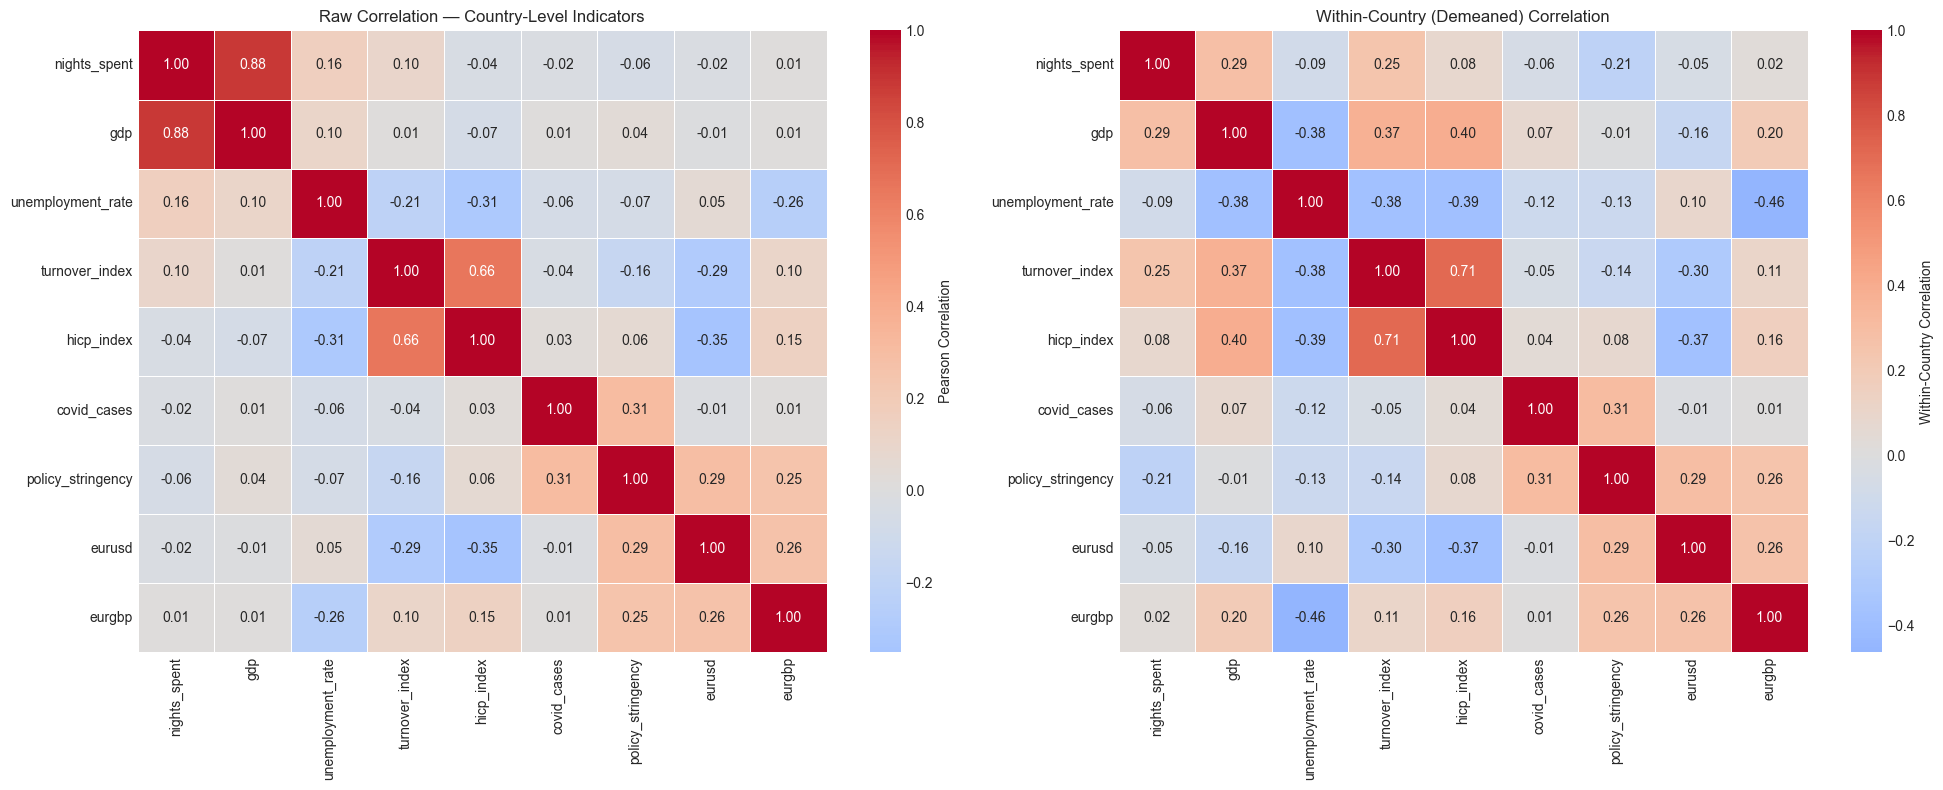

[INFO] Top within-country correlated indicators with nights spent:


,Within-Country Corr. with Nights Spent
nights_spent,1.000
gdp,0.288
turnover_index,0.249
hicp_index,0.083
eurgbp,0.024
eurusd,-0.050
covid_cases,-0.060
unemployment_rate,-0.087
policy_stringency,-0.210


[INFO] Correlation matrices exported to docs/ directory.


In [16]:
# --- Define Numeric Columns of Interest ---
numeric_cols = [
    "nights_spent", "gdp", "unemployment_rate",
    "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]
corr_cols = [c for c in numeric_cols if c in eda.columns]
print(f"[INFO] Using {len(corr_cols)} numeric variables for correlation analysis.")

# --- Compute Pearson Correlation (Raw) ---
corr_raw = eda[corr_cols].corr(method="pearson")

# --- Compute Within-Country Demeaned Correlation ---
eda_demeaned = eda.copy()
for col in corr_cols:
    eda_demeaned[col] = eda.groupby("region")[col].transform(lambda x: x - x.mean())
corr_within = eda_demeaned[corr_cols].corr(method="pearson")

# --- Optional: Spearman (rank-based) correlation ---
corr_spearman = eda[corr_cols].corr(method="spearman")

# --- Visualization: side-by-side heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    corr_raw, cmap="coolwarm", center=0, annot=True, fmt=".2f",
    cbar_kws={"label": "Pearson Correlation"}, linewidths=0.5, ax=axes[0]
)
axes[0].set_title("Raw Correlation — Country-Level Indicators")

sns.heatmap(
    corr_within, cmap="coolwarm", center=0, annot=True, fmt=".2f",
    cbar_kws={"label": "Within-Country Correlation"}, linewidths=0.5, ax=axes[1]
)
axes[1].set_title("Within-Country (Demeaned) Correlation")

plt.tight_layout()

# --- Save both heatmaps ---
output_path = Path("../docs")
output_path.mkdir(parents=True, exist_ok=True)

save_path = output_path / "correlation_heatmap_within_vs_raw.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"[INFO] Correlation comparison heatmap saved to: {save_path}")

plt.show()

# --- Identify Top Correlated Indicators with Hotel Nights ---
top_corr = (
    corr_within["nights_spent"]
    .sort_values(ascending=False)
    .to_frame("Within-Country Corr. with Nights Spent")
    .round(3)
)
print("[INFO] Top within-country correlated indicators with nights spent:")
display(top_corr)

# --- Optional: also export correlation matrices ---
corr_raw.to_csv(output_path / "corr_raw.csv")
corr_within.to_csv(output_path / "corr_within_country.csv")
corr_spearman.to_csv(output_path / "corr_spearman.csv")
print("[INFO] Correlation matrices exported to docs/ directory.")


### 🟩 13. Cluster Analysis of Recovery Patterns

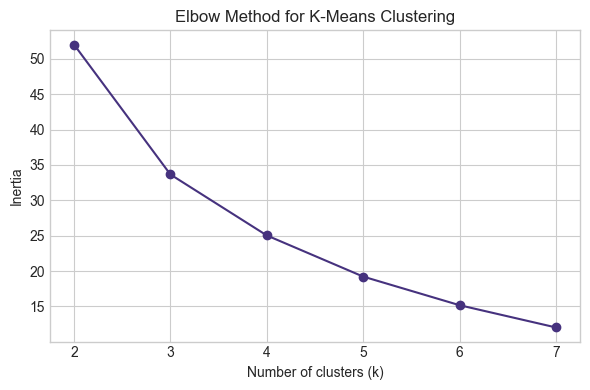

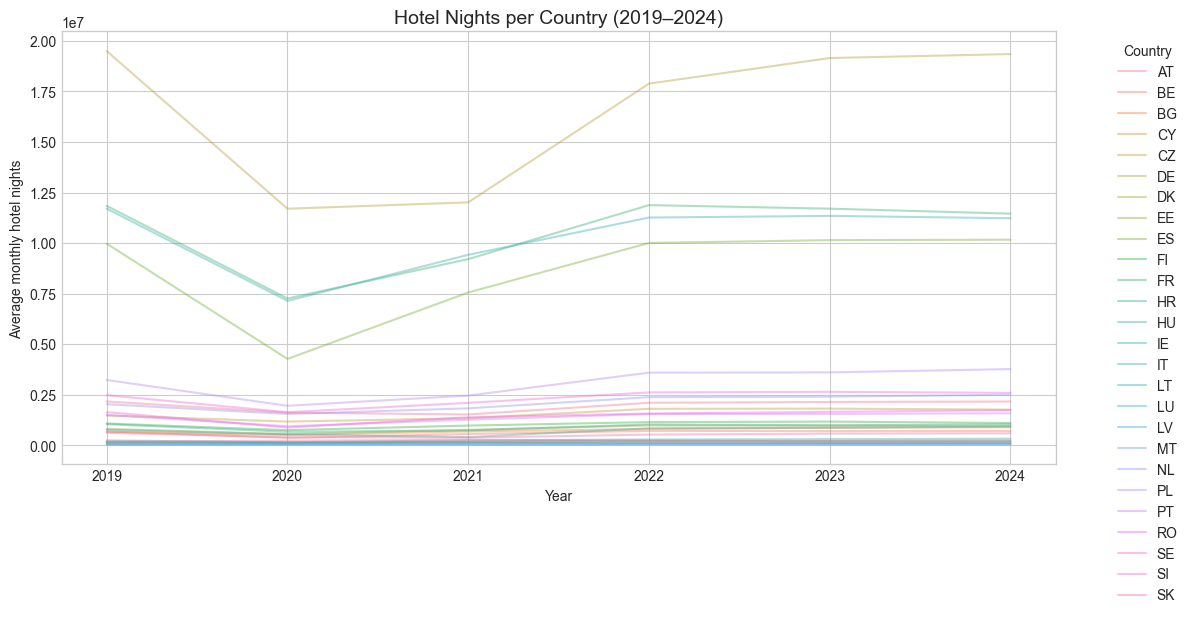

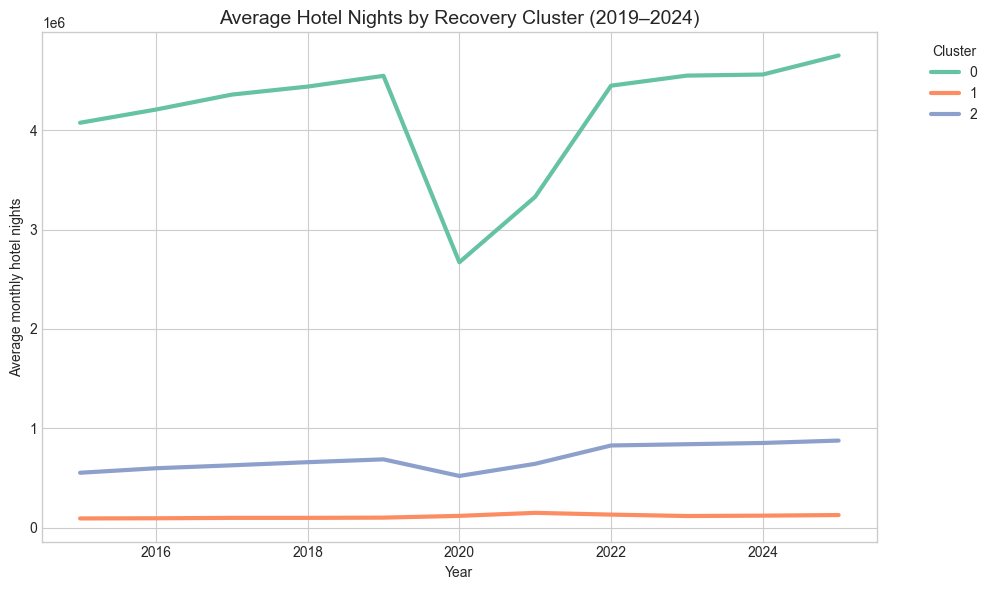

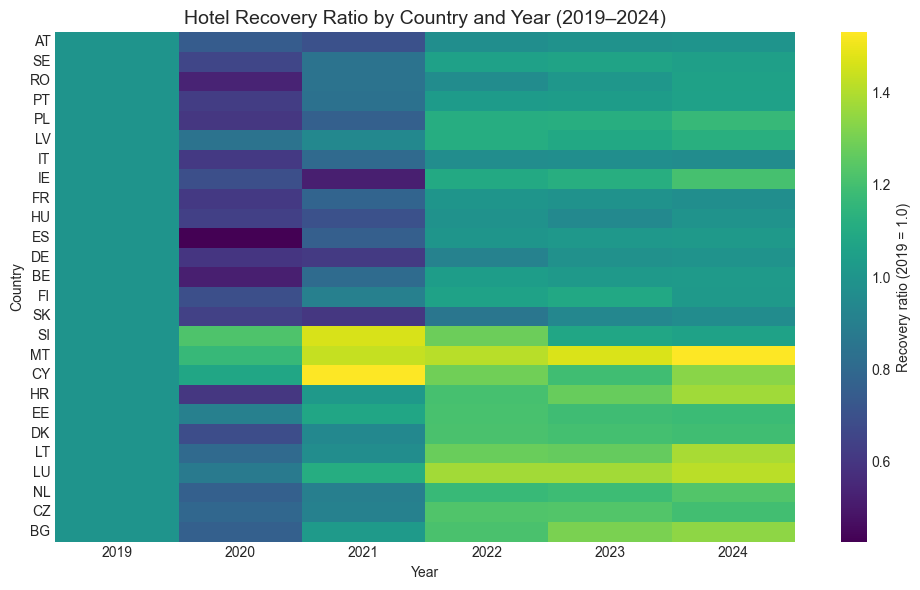

📊 Cluster Summary:


year,2019,2020,2021,2022,2023,2024,size
cluster,,,,,,,
0,1.0,0.63,0.76,1.01,1.02,1.04,15
1,1.0,1.16,1.48,1.33,1.25,1.31,3
2,1.0,0.77,0.99,1.24,1.25,1.29,8


In [17]:
# --- Focus on 2019–2024 period (COVID and recovery) ---
recovery = (
    eda[eda["year"].between(2019, 2024)]
    .groupby(["region", "year"])["nights_spent"]
    .mean()
    .reset_index()
)

# Pivot → countries × years
recovery_pivot = recovery.pivot(index="region", columns="year", values="nights_spent")

# Normalize relative to 2019 baseline (Recovery ratio)
recovery_pivot = recovery_pivot.div(recovery_pivot[2019], axis=0)

# Fill any missing years (forward and backward)
recovery_pivot = recovery_pivot.ffill(axis=1).bfill(axis=1)

# --- Clustering preparation ---
X = StandardScaler().fit_transform(recovery_pivot)

# --- Elbow method (determine number of clusters) ---
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 8), inertia, marker="o")
plt.title("Elbow Method for K-Means Clustering")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

# --- Choose k=3 for interpretability ---
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
recovery_pivot["cluster"] = kmeans.fit_predict(X)

# Merge cluster labels back into main dataset
eda = eda.merge(
    recovery_pivot["cluster"].rename("recovery_cluster"),
    on="region",
    how="left"
)

# Define a consistent color palette
cluster_palette = sns.color_palette("Set2", n_colors=3)

# --- Visualization 1: Country-level lines ---
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=recovery,
    x="year", y="nights_spent", hue="region",
    estimator=None, alpha=0.4
)
plt.title("Hotel Nights per Country (2019–2024)", fontsize=14)
plt.ylabel("Average monthly hotel nights")
plt.xlabel("Year")
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Country",
    frameon=False,
    ncol=1
)
plt.tight_layout()
plt.show()

# --- Visualization 2: Cluster-level average trajectories ---
cluster_mean = (
    eda.groupby(["recovery_cluster", "year"])["nights_spent"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=cluster_mean,
    x="year", y="nights_spent", hue="recovery_cluster",
    palette=cluster_palette, linewidth=3
)
plt.title("Average Hotel Nights by Recovery Cluster (2019–2024)", fontsize=14)
plt.ylabel("Average monthly hotel nights")
plt.xlabel("Year")
plt.legend(
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False
)
plt.tight_layout()
plt.show()

# --- Visualization 3: Recovery ratio heatmap ---
plt.figure(figsize=(10,6))
heatmap_data = recovery_pivot.sort_values("cluster").drop(columns="cluster")
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    cbar_kws={'label': 'Recovery ratio (2019 = 1.0)'}
)
plt.title("Hotel Recovery Ratio by Country and Year (2019–2024)", fontsize=14)
plt.ylabel("Country")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

# --- Cluster summary table ---
cluster_summary = (
    recovery_pivot.groupby("cluster")
    .mean()
    .assign(size=recovery_pivot["cluster"].value_counts().sort_index())
)
print("📊 Cluster Summary:")
display(cluster_summary.round(2))

### 🟩 14. Summary Findings & Export

In [18]:
# --- Summary Findings & Export ---

summary = {
    "total_countries": eda["region"].nunique(),
    "time_range": (eda["month"].min().strftime("%Y-%m"), eda["month"].max().strftime("%Y-%m")),
    "missing_share": eda.isna().mean().round(4).to_dict(),
    "clusters": eda["recovery_cluster"].nunique(),
    "avg_recovery_by_cluster": eda.groupby("recovery_cluster")["nights_spent"].mean().round(0).to_dict()
}

summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["value"])
display(summary_df)

# Save summary to file
summary_df.to_csv("../data/processed/eda_summary.csv")
print("💾 Summary exported → ../data/processed/eda_summary.csv")

# Optional: Save country-cluster assignments
cluster_labels = (
    eda[["region", "recovery_cluster"]].drop_duplicates().sort_values("region")
)
cluster_labels.to_csv("../data/processed/country_clusters.csv", index=False)
print("💾 Cluster assignments exported → ../data/processed/country_clusters.csv")

,value
total_countries,26
time_range,"(2015-01, 2025-08)"
missing_share,"{'region': 0.0, 'month': 0.0, 'year': 0.0, 'ni..."
clusters,3
avg_recovery_by_cluster,"{0: 4157665.0, 1: 112660.0, 2: 692385.0}"


💾 Summary exported → ../data/processed/eda_summary.csv
💾 Cluster assignments exported → ../data/processed/country_clusters.csv
